In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import os
from PIL import Image

import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import torch
from torch.utils.data import DataLoader
from scipy.sparse import csr_matrix


In [42]:
train_path_cat = '/media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Train_Color/Cat'
train_path_dog = '/media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Train_Color/Dog'
train_labels = pd.read_csv('/media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Train_Color/labels.csv')

valid_path_cat = '/media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Val_Color/Cat'
valid_path_dog = '/media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Val_Color/Dog'
valid_labels = pd.read_csv('/media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Val_Color/labels.csv')

In [44]:
train_labels.tail()

,name,label
21991,/media/ryan/New Volume/datasets/kagglecatsandd...,1
21992,/media/ryan/New Volume/datasets/kagglecatsandd...,1
21993,/media/ryan/New Volume/datasets/kagglecatsandd...,1
21994,/media/ryan/New Volume/datasets/kagglecatsandd...,1
21995,/media/ryan/New Volume/datasets/kagglecatsandd...,1


In [45]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [46]:
train_cat_image_paths = [os.path.join(train_path_cat, img_name) for img_name in os.listdir(train_path_cat)]
train_dog_image_paths = [os.path.join(train_path_dog, img_name) for img_name in os.listdir(train_path_dog)]

valid_cat_image_paths = [os.path.join(valid_path_cat, img_name) for img_name in os.listdir(valid_path_cat)]
valid_dog_image_paths = [os.path.join(valid_path_dog, img_name) for img_name in os.listdir(valid_path_dog)]

In [47]:
# Combine training set paths and labels
train_image_paths = train_cat_image_paths + train_dog_image_paths


# Combine validation set paths and labels
valid_image_paths = valid_cat_image_paths + valid_dog_image_paths


# Create datasets and data loaders for training and validation sets
train_dataset = CustomDataset(train_image_paths, train_labels)
valid_dataset = CustomDataset(valid_image_paths, valid_labels)

# Create data loaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



In [48]:
train_dataset

In [82]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the input for fully connected layers
        x = x.view(-1, 32 * 64 * 64)
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [83]:
num_classes = len(df['label'].unique())
print(num_classes)

2


In [84]:
model = SimpleCNN(num_classes)  
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [85]:
print(torch.__version__)
print(torch.version.cuda)

2.3.0+cu121
12.1


In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print out the device being used
print("Using device:", device)

Using device: cuda


In [87]:
print(len(train_image_paths))
print(len(train_labels))


21996
21996


In [88]:
train_image_paths[4357]

'/media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Train_Color/Cat/4015.jpg'

In [89]:
from fastai.vision.all import *

In [90]:
# Define paths to your dataset
path = Path('/media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages')
item_tfms = [Resize((256, 256))]
# Define DataLoader using DataBlock API
dls = ImageDataLoaders.from_folder(path, train='Train_Color', valid='Val_Color', bs=32, item_tfms=item_tfms)

# Define CNN architecture
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

learn.to(device)
# Train the model
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [70]:
learn.save('/media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/cnn_20_epochs.pth')

Path('/media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/cnn_20_epochs.pth.pth')

In [74]:
data = """
epoch train_loss valid_loss accuracy time
0 0.461244 0.464090 0.782391 00:14
1 0.448396 0.476350 0.760880 00:14
2 0.455525 0.455641 0.791896 00:14
3 0.432976 0.542695 0.739870 00:14
4 0.408904 0.466399 0.790895 00:14
5 0.415590 0.438406 0.796398 00:14
6 0.387382 0.466445 0.777889 00:14
7 0.377856 0.413877 0.816908 00:14
8 0.348794 0.449697 0.800900 00:14
9 0.328294 0.425533 0.808904 00:14
10 0.306292 0.434824 0.808904 00:14
11 0.284561 0.437903 0.817409 00:14
12 0.269224 0.443900 0.802901 00:14
13 0.271098 0.431568 0.810405 00:14
14 0.255365 0.439781 0.812906 00:14
15 0.238731 0.425553 0.821411 00:14
16 0.213861 0.440628 0.820910 00:14
17 0.229104 0.439719 0.817909 00:14
18 0.215454 0.439314 0.824412 00:14
19 0.210778 0.441086 0.824412 00:14
"""

# Split the data by lines
lines = data.strip().split('\n')

# Initialize lists for each column
epochs = []
train_loss = []
valid_loss = []
accuracy = []
time = []

# Iterate over each line and extract values for each column
for line in lines[1:]:  # Skip the first line as it contains column names
    cols = line.split()  # Split the line by whitespace
    epochs.append(int(cols[0]))
    train_loss.append(float(cols[1]))
    valid_loss.append(float(cols[2]))
    accuracy.append(float(cols[3]))
    time.append(cols[4])

# Print the lists
print("Epochs:", epochs)
print("Train Loss:", train_loss)
print("Valid Loss:", valid_loss)
print("Accuracy:", accuracy)
print("Time:", time)

Epochs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Train Loss: [0.461244, 0.448396, 0.455525, 0.432976, 0.408904, 0.41559, 0.387382, 0.377856, 0.348794, 0.328294, 0.306292, 0.284561, 0.269224, 0.271098, 0.255365, 0.238731, 0.213861, 0.229104, 0.215454, 0.210778]
Valid Loss: [0.46409, 0.47635, 0.455641, 0.542695, 0.466399, 0.438406, 0.466445, 0.413877, 0.449697, 0.425533, 0.434824, 0.437903, 0.4439, 0.431568, 0.439781, 0.425553, 0.440628, 0.439719, 0.439314, 0.441086]
Accuracy: [0.782391, 0.76088, 0.791896, 0.73987, 0.790895, 0.796398, 0.777889, 0.816908, 0.8009, 0.808904, 0.808904, 0.817409, 0.802901, 0.810405, 0.812906, 0.821411, 0.82091, 0.817909, 0.824412, 0.824412]
Time: ['00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14', '00:14']


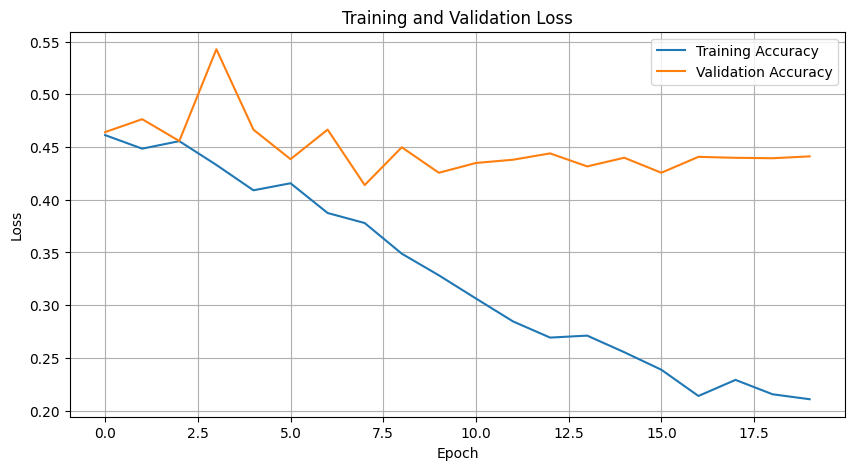

In [77]:
# Plotting

plt.figure(figsize=(10, 5))
plt.plot(range(len(epochs)), train_loss, label='Training Accuracy')
plt.plot(range(len(epochs)), valid_loss, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
#plt.savefig('loss_plot.png')  # Save the plot as an image
plt.show()

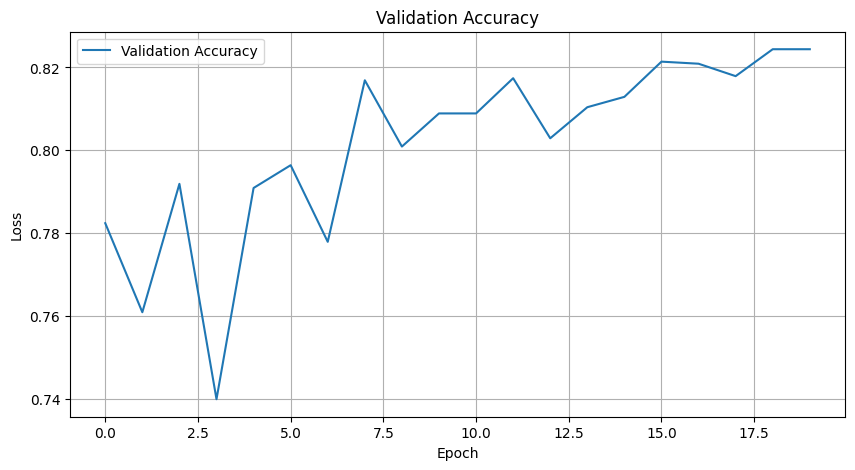

In [78]:
# Plotting

plt.figure(figsize=(10, 5))
plt.plot(range(len(epochs)), accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
#plt.savefig('loss_plot.png')  # Save the plot as an image
plt.show()

In [91]:
# Define paths to your dataset
path = Path('/media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages')
item_tfms = [Resize((256, 256))]
# Define DataLoader using DataBlock API
dls = ImageDataLoaders.from_folder(path, train='Train_Color', valid='Val_Color', bs=32, item_tfms=item_tfms)

# Define CNN architecture
learn2 = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

learn2.to(device)
# Train the model
learn2.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.651215,0.618735,0.668834,00:14
1,0.567614,0.565125,0.707354,00:14
2,0.509225,0.491004,0.764882,00:14
3,0.465305,0.465914,0.783392,00:14
4,0.436844,0.456405,0.786393,00:14


/home/ryan/anaconda3/envs/catdog/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/ryan/anaconda3/envs/catdog/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/ryan/anaconda3/envs/catdog/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/ryan/anaconda3/envs/catdog/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/ryan/anaconda3/envs/catdog/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
